<a href="https://colab.research.google.com/github/khmelkoff/TraxRuSummarizer/blob/main/TraxRuSummarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install trax

     |████████████████████████████████| 522kB 8.0MB/s 
     |████████████████████████████████| 215kB 34.7MB/s 
     |████████████████████████████████| 3.4MB 37.8MB/s 
     |████████████████████████████████| 368kB 52.6MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 3.8MB 55.3MB/s 
     |████████████████████████████████| 1.2MB 60.8MB/s 
     |████████████████████████████████| 1.8MB 59.3MB/s 
     |████████████████████████████████| 890kB 59.3MB/s 
     |████████████████████████████████| 2.9MB 52.2MB/s 


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
# from unicodedata import normalize
# import sentencepiece as spm

import trax
from trax import layers as tl
# from trax.fastmath import numpy as jnp

%matplotlib inline

In [4]:
import textwrap
wrapper = textwrap.TextWrapper(width=70)

## Load the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/lenta-ru-news.csv.zip')
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


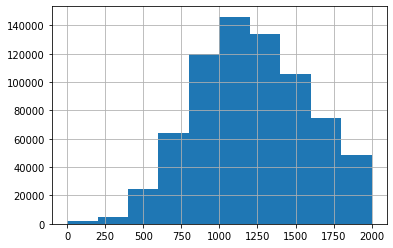

In [8]:
data['text_len'] = [len(x) if not type(x)==float else 0 for x in data.text]
data.text_len[data.text_len < 2000].hist()

In [9]:
# text_full = []  # full text list for train senttence piece tokenizer
text_pairs = [] # paired data for train the model, format: (title, text)
for i in tqdm(range(data.shape[0])):
    if data.iloc[i, 6] >= 200 and data.iloc[i, 6] <= 2000:
        # text_full.append(data.iloc[i, 1].lower() + '\n' + data.iloc[i, 2].lower())
        # list of (article, summary)
        text_pairs.append((data.iloc[i, 2].lower(), data.iloc[i, 1].lower()))

# save full text to text file        
# with open('full_text.txt', 'w', encoding='utf-8') as file:
#     file.write('\n'.join(text_full))  

100%|██████████| 800975/800975 [01:04<00:00, 12332.69it/s]


In [8]:
text_pairs[0]

('бои у сопоцкина и друскеник закончились отступлением германцев. неприятель, приблизившись с севера к осовцу начал артиллерийскую борьбу с крепостью. в артиллерийском бою принимают участие тяжелые калибры. с раннего утра 14 сентября огонь достиг значительного напряжения. попытка германской пехоты пробиться ближе к крепости отражена. в галиции мы заняли дембицу. большая колонна, отступавшая по шоссе от перемышля к саноку, обстреливалась с высот нашей батареей и бежала, бросив парки, обоз и автомобили. вылазки гарнизона перемышля остаются безуспешными. при продолжающемся отступлении австрийцев обнаруживается полное перемешивание их частей, захватываются новые партии пленных, орудия и прочая материальная часть. на перевале ужок мы разбили неприятельский отряд, взяли его артиллерию и много пленных и, продолжая преследовать, вступили в пределы венгрии. \n«русский инвалид», 16 сентября 1914 года.',
 '1914. русские войска вступили в\xa0пределы венгрии  ')

## Load / Train BPE tokenizer

In [9]:
# train tokenizer
# spm.SentencePieceTrainer.train('--input=full_text.txt --pad_id=0 --bos_id=-1 --eos_id=1 --unk_id=2 \
#                                --model_prefix=bpe --vocab_size=32000 --model_type=bpe')
# sp = spm.SentencePieceProcessor()
# sp.load('/content/drive/MyDrive/bpe.model')

In [10]:
s0 = text_pairs[10][0]
text_list = wrapper.wrap(s0[:300])
for line in text_list:
    print(line)

сегодня областной центр сахалина и курил получил статус очага
распространения холеры. как сообщает итар-тасс со ссылкой на пресс-
центр администрации сахалинской области, в лечебных учреждениях южно-
сахалинска уже находятсятся 5 горожан, причем у двоих из них болезнь
проходит в средне-тяжелой форме.


In [11]:
# # tokenizer check
# print('encode: text => id:')
# print(sp.encode_as_pieces(s0[:300]))
# print('')
# print(sp.encode_as_ids(s0[:300]))
# print('')
# print('decode: id => text:')
# print(sp.decode_pieces(sp.encode_as_pieces(s0[:300])))
# print('')
# print(f'Beginning of sentence id: {sp.bos_id()}')
# print(f'Pad id: {sp.pad_id()}')
# print(f'End of sentence id: {sp.eos_id()}')
# print(f'Unknown id: {sp.unk_id()}')
# print(f'Vocab size: {sp.vocab_size()}')      

In [12]:
# uid = 18298
# spiece = "\u2581Саха"
# unknown = "_НЕИЗВЕСТНОСТЬ_"

# # id <=> piece conversion
# print(f'SentencePiece for ID {uid}: {sp.id_to_piece(uid)}')
# print(f'ID for Sentence Piece {spiece}: {sp.piece_to_id(spiece)}')

# # returns 0 for unknown tokens (we can change the id for UNK)
# print(f'ID for unknown text {unknown}: {sp.piece_to_id(unknown)}')

In [13]:
# # vocab's head and tail test
# print('\nId\tSentP\tControl?')
# print('------------------------')
# for uid in range(7):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')
    
# for uid in range(sp.vocab_size()-7,sp.vocab_size()):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')

## Data: preprocess and create generators

In [12]:
# inintial shuffling
random.shuffle(text_pairs)
margin = int(len(text_pairs)*0.95)
train_text_pairs = text_pairs[:margin]
print('train cases: ', len(train_text_pairs))
eval_text_pairs = text_pairs[margin:]
print('eval cases: ', len(eval_text_pairs))

train cases:  686277
eval cases:  36120


In [13]:
def data_generator(data, shuffle=True):
    '''
      Input: 
        data - list containing tuples (article, summary)
        shuffle - If True: shuffle the data order
      Output:
        a tuple containing 2 elements:
        article
        summary
    '''
    
    data_lng = len(data) # len(data)
    index_list = [*range(data_lng)] # Create a list with the ordered indexes of sample data
    
    index = 0 # Start with the first element
    while True:
        # Wrap the index each time that we reach the end of the list
        if index >= data_lng:
            index = 0
            if shuffle:
                random.shuffle(index_list) # re-shuffle the order
            
        sample = data[index_list[index]]
        index += 1
        yield(sample)

# create data streams
def train_data_stream():
    return data_generator(train_text_pairs, shuffle=True)

def eval_data_stream():
    return data_generator(eval_text_pairs, shuffle=True)        

In [14]:
PAD, EOS, UNK = 0, 1, 2

def detokenize(np_array):
    return trax.data.detokenize(
        np_array,
        vocab_type='sentencepiece',
        vocab_file='bpe.model',
        vocab_dir='/content/drive/MyDrive/')


def tokenize(s):
    return next(trax.data.tokenize(
        iter([s]),
        vocab_type='sentencepiece',
        vocab_file='bpe.model',
        vocab_dir='/content/drive/MyDrive/'))
 
    
vocab_size = trax.data.vocab_size(
    vocab_type='sentencepiece',
    vocab_file='bpe.model',
    vocab_dir='/content/drive/MyDrive/')

print('vocab size: ', vocab_size)

vocab size:  16000


In [15]:
tokenize('тест')

array([15117])

In [16]:
tokenize('НЕИЗВЕСТНОСТЬ')

array([15924,     2])

In [ ]:
tokenized = tokenize('сведения о пассажирах на всех видах транспорта, где используются именные проездные билеты')
print('tokenized:')
print(tokenized)
print('len=', len(tokenized))
detokenized = detokenize(tokenized)
print('detokenized:')
print(detokenized)
print('len=', len(detokenized.split()))

In [18]:
# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, PAD] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) 
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_type='sentencepiece',
                       vocab_dir='/content/drive/MyDrive/',
                       vocab_file='bpe.model'),
    # Uses function defined above
    preprocess,
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_data_stream())
eval_stream = input_pipeline(eval_data_stream())

In [19]:
train_input, train_target, train_mask = next(train_stream)
# assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).

In [20]:
# check pad (id:0) and sep/eos (id:1)
print(train_input[-20:])

[ 5686  6144 15949     1     0     5  6603  9235  6329  1825  4429  9664
 15938   860    26  4843  1868  4746    38     1]


## Batching and Bucketing 

In [21]:
# batch of 8 sentences of length < 256 , 4 of length < 512....
boundaries =  [256, 512, 1024]
batch_sizes = [16, 8, 4, 2]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [22]:
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(8, 512)

In [23]:
# check autopadding endig of sample
# 1, 0, <not 0 digit>... - end of article and start of summary
input_batch[0]

array([  618,  3873, 13538,   188,  1768,  7407,  2435,   203,  4008,
         167,  3774, 15982,  3589, 10085,  1842,  1443, 15963,   585,
       15977,   455, 15945,    79,   401,    57,  4895,  2965,    64,
        1130,   254,  8254,  8778,   296,  1828, 10980, 15949,   207,
         258,  4817,  3528, 15960,  4742,    48,   867,    25,  4739,
         203,  1447, 15945,  3873, 13538,   369,  7511,  6193,  2962,
         957, 12502, 15949,   110,   306,    15,    86, 15933,    35,
          57,  9418,     5,  2570,   167,    80,  1099,   810,   296,
        1828, 10980,   210,  6222, 15949,   110,  2719, 15949,    53,
        4513,  1484,  2964,  1442,  1510,    57,  1356,  6023,    54,
        4706,    36,    16,  6156,  1130,   862,   291,   210,  1956,
         915,  1654, 15945,  8046, 15945,    79,    43,  1586,  1574,
         314,  8003,  4010, 15945,   749, 11846,   129, 15949,    78,
         226,     5,   278,  2644, 15945,    79,   296,  1828,  2522,
         348,  1611,

## Transformer Model

### Positional encoder

In [24]:
def PositionalEncoder(vocab_size, d_model, dropout, max_len, mode):
    """Returns a list of layers that: 
    1. takes a block of text as input, 
    2. embeds the words in that text, and 
    3. adds positional encoding, 
       i.e. associates a number in range(max_len) with 
       each word in each sentence of embedded input text 
    
    The input is a list of tokenized blocks of text
    
    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train' or 'eval'.
    """
    # Embedding inputs and positional encoder
    return [ 
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),  
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode), 
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)] 

### Feed-Forward layer

In [25]:
def FeedForward(d_model, d_ff, dropout, mode, ff_activation):
    """Returns a list of layers that implements a feed-forward block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
    
    # Feed-forward block (list) with two dense layers with dropout and input normalized
    return [ 
        # Normalize layer inputs
        tl.LayerNorm(), 
        # Add first feed forward (dense) layer
        tl.Dense(d_ff), 
        # Add activation function passed in as a parameter
        ff_activation(),  # ReLU
        # Add dropout with rate and mode specified (don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode), 
        # Add second feed forward layer
        tl.Dense(d_model), 
        # Add dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode) 
    ]

### Decoder Block

In [26]:
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    """Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
        
    # List of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(), 
          # Add causal attention 
          tl.CausalAttention(d_model, n_heads=n_heads, dropout=dropout, mode=mode) 
        ),
      tl.Residual(
          # Add feed-forward block
          # The feed-forward block takes care of normalization
          FeedForward(d_model, d_ff, dropout, mode, ff_activation)
        ),
      ]

### Trnsformer (decoder)

In [27]:
def SumTransformer(vocab_size=vocab_size,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """
    
    # Stack of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [ 
        DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)] 

    # The complete model
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(mode=mode), 
        # Add embedding inputs and positional encoder
        PositionalEncoder(vocab_size, d_model, dropout, max_len, mode),
        # Add decoder blocks
        decoder_blocks, 
        # Normalize layer
        tl.LayerNorm(), 

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size), 
        # Get probabilities with Logsoftmax
        tl.LogSoftmax() 
    )

In [28]:
print(SumTransformer(n_layers=1))

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_16000_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Serial[
            Serial[
              Branch_out3[
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
              ]
              DotProductCausalAttention_in3
              Serial[
                MergeHeads
              ]
              Dense_512
            ]
          ]
        ]
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_16000
  LogSoftmax
]


## Training

In [29]:
from trax.supervised import training

def training_loop(SumTransformer, train_gen, eval_gen, output_dir = "~/model"):
    '''
    Input:
        SumTransformer (trax.layers.combinators.Serial): The transformer model.
        train_gen (generator): Training stream of data.
        eval_gen (generator): Evaluation stream of data.
        output_dir (str): folder to save your file.
        
    Returns:
        trax.supervised.training.Loop: Training loop.
    '''
    output_dir = os.path.expanduser(output_dir)  # trainer is an object
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=4000, max_value=0.00025)

    train_task = training.TrainTask( 
      labeled_data=train_gen, # The training generator
      loss_layer=tl.CrossEntropyLoss(), # Loss function 
      optimizer=trax.optimizers.Adam(0.00025), # Optimizer 
      lr_schedule=lr_schedule,
      n_steps_per_checkpoint=100
    )

    eval_task = training.EvalTask( 
      labeled_data=eval_gen, 
      metrics=[tl.CrossEntropyLoss(), tl.Accuracy()] 
    )

    loop = training.Loop(SumTransformer(d_model=512,
                                       d_ff=2048,
                                       n_layers=8,
                                       n_heads=8,
                                       mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)
    
    return loop

In [30]:
# Should take around 1 minute per 100 step on GPU
!rm -f ~/model/model.pkl.gz
loop = training_loop(SumTransformer, train_batch_stream, eval_batch_stream)
loop.run(40000)


Step      1: Total number of trainable weights: 43717248
Step      1: Ran 1 train steps in 50.18 secs
Step      1: train CrossEntropyLoss |  9.68462372
Step      1: eval  CrossEntropyLoss |  9.71015549
Step      1: eval          Accuracy |  0.00000000

Step    100: Ran 99 train steps in 78.49 secs
Step    100: train CrossEntropyLoss |  9.50323772
Step    100: eval  CrossEntropyLoss |  9.24096298
Step    100: eval          Accuracy |  0.06722689

Step    200: Ran 100 train steps in 57.52 secs
Step    200: train CrossEntropyLoss |  9.09789276
Step    200: eval  CrossEntropyLoss |  8.85563660
Step    200: eval          Accuracy |  0.08421053

Step    300: Ran 100 train steps in 80.71 secs
Step    300: train CrossEntropyLoss |  8.78112698
Step    300: eval  CrossEntropyLoss |  8.64203930
Step    300: eval          Accuracy |  0.07920792

Step    400: Ran 100 train steps in 58.56 secs
Step    400: train CrossEntropyLoss |  8.48059654
Step    400: eval  CrossEntropyLoss |  8.35955620
Step  

In [39]:
!cp ~/model/model.pkl.gz /content/drive/MyDrive/model/


In [36]:
!rsync -a ~/model /content/drive/MyDrive/model2/